In [1]:
import pandas as pd
import numpy as np

# Carga
df = pd.read_csv("specphoto_dr19_500k_STAR_GAL_QSO.csv")

# Colores fotométricos a partir de psfMag
df["u_g"] = df["psfMag_u"] - df["psfMag_g"]
df["g_r"] = df["psfMag_g"] - df["psfMag_r"]
df["r_i"] = df["psfMag_r"] - df["psfMag_i"]
df["i_z"] = df["psfMag_i"] - df["psfMag_z"]

features_colors = ["u_g","g_r","r_i","i_z"]
target = "class"

# Conjunto limpio para clasificación
dft = df.dropna(subset = features_colors + [target]).copy()

print("Distribución de clases (dataset limpio):")
print(dft[target].value_counts())


Distribución de clases (dataset limpio):
class
GALAXY    315305
STAR      148513
QSO        36182
Name: count, dtype: int64


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_all = dft[features_colors].values.astype(np.float64)
y_all = dft[target].values

scaler_pca = StandardScaler()
X_all_scaled = scaler_pca.fit_transform(X_all)

pca = PCA(n_components = 4, random_state = 42)
Z = pca.fit_transform(X_all_scaled)

print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 3))

loadings = pd.DataFrame(
    pca.components_,
    columns = features_colors,
    index = [f"PC{i + 1}" for i in range(4)]
)
loadings


Explained variance ratio: [0.448 0.302 0.17  0.079]


,u_g,g_r,r_i,i_z
PC1,0.535576,-0.144098,-0.547921,0.626240
PC2,0.023182,0.854275,-0.465378,-0.230434
PC3,0.844159,0.065599,0.357562,-0.394007
PC4,0.004031,0.495122,0.596117,0.632046


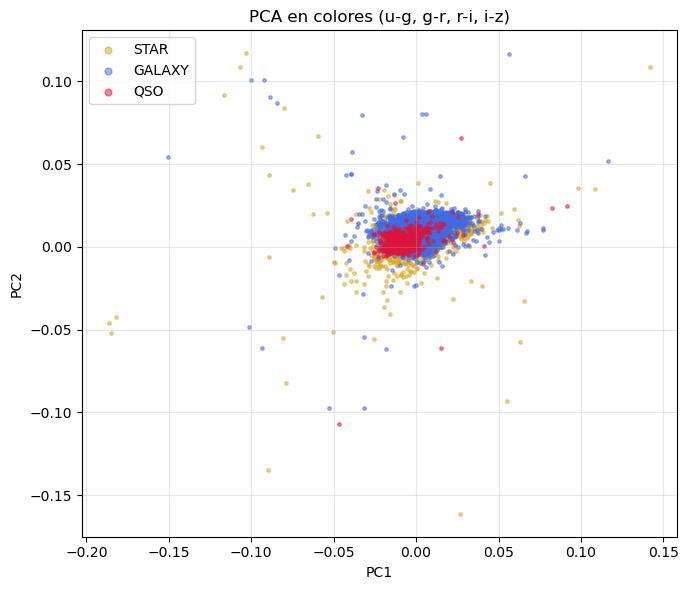

In [3]:
import matplotlib.pyplot as plt
idx = np.random.RandomState(42).choice(len(Z), size = min(20000, len(Z)), replace = False)
Zs = Z[idx]
ys = y_all[idx]

plt.figure(figsize = (7,6))
for cls, col in zip(["STAR","GALAXY","QSO"], ["goldenrod","royalblue","crimson"]):
    mask = (ys == cls)
    plt.scatter(Zs[mask,0], Zs[mask,1], s = 6, alpha = 0.5, label = cls, color = col)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA en colores (u-g, g-r, r-i, i-z)")
plt.legend(markerscale = 2)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = dft[features_colors].values.astype(np.float64)
y = dft[target].values

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = y,
    random_state = 42
)

# Codificamos etiquetas
le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
y_te_enc = le.transform(y_te)


In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

scaler_clf = StandardScaler()
X_trs = scaler_clf.fit_transform(X_tr)
X_tes = scaler_clf.transform(X_te)

mlp_base = MLPClassifier(
    hidden_layer_sizes = (64,32),
    activation = "relu",
    solver = "adam",
    learning_rate_init = 1e-3,
    alpha = 1e-4,
    max_iter = 600,
    early_stopping = True,
    n_iter_no_change = 10,
    validation_fraction = 0.1,
    random_state = 42
)

mlp_base.fit(X_trs, y_tr_enc)

y_pred_enc = mlp_base.predict(X_tes)
y_pred_base = le.inverse_transform(y_pred_enc)

print("BASELINE (sin remuestreo)")
print(classification_report(y_te, y_pred_base, digits = 3))


BASELINE (sin re-muestreo)
              precision    recall  f1-score   support

      GALAXY      0.933     0.947     0.940     63061
         QSO      0.893     0.820     0.855      7236
        STAR      0.897     0.887     0.892     29703

    accuracy                          0.920    100000
   macro avg      0.908     0.884     0.895    100000
weighted avg      0.919     0.920     0.919    100000



In [6]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

def eval_with_resampling(resampler, name):
    # remuestreamos solo train con las etiquetas codificadas
    X_tr_res, y_tr_res_enc = resampler.fit_resample(X_tr, y_tr_enc)

    scaler_r = StandardScaler()
    X_trs_res = scaler_r.fit_transform(X_tr_res)
    X_tes_res = scaler_r.transform(X_te)

    clf = MLPClassifier(
        hidden_layer_sizes = (64,32),
        activation = "relu",
        solver = "adam",
        learning_rate_init = 1e-3,
        alpha = 1e-4,
        max_iter = 600,
        early_stopping = True,
        random_state = 42
    )
    clf.fit(X_trs_res, y_tr_res_enc)

    y_pred_enc = clf.predict(X_tes_res)
    y_pred = le.inverse_transform(y_pred_enc)

    print(f"\n=== {name} ===")
    print(classification_report(y_te, y_pred, digits = 3))
    return clf, scaler_r, y_pred

ros = RandomOverSampler(random_state = 42)
clf_over, scaler_over, y_pred_over = eval_with_resampling(
    ros, "OVERSAMPLING"
)

rus = RandomUnderSampler(random_state = 42)
clf_under, scaler_under, y_pred_under = eval_with_resampling(
    rus, "UNDERSAMPLING"
)

sm = SMOTE(random_state = 42, k_neighbors = 5)
clf_smote, scaler_smote, y_pred_smote = eval_with_resampling(
    sm, "OVERSAMPLING (con SMOTE)"
)



=== OVERSAMPLING ===
              precision    recall  f1-score   support

      GALAXY      0.957     0.897     0.926     63061
         QSO      0.676     0.918     0.779      7236
        STAR      0.873     0.912     0.892     29703

    accuracy                          0.903    100000
   macro avg      0.835     0.909     0.866    100000
weighted avg      0.912     0.903     0.905    100000


=== UNDERSAMPLING ===
              precision    recall  f1-score   support

      GALAXY      0.951     0.892     0.921     63061
         QSO      0.702     0.902     0.789      7236
        STAR      0.853     0.904     0.878     29703

    accuracy                          0.897    100000
   macro avg      0.835     0.900     0.863    100000
weighted avg      0.904     0.897     0.898    100000


=== OVERSAMPLING (con SMOTE) ===
              precision    recall  f1-score   support

      GALAXY      0.958     0.905     0.931     63061
         QSO      0.736     0.908     0.813      7

N galaxias con z: 315305
Train GALAXY: (252244, 5) Test GALAXY: (63061, 5)
[GALAXY] bias(Δz/(1+z))   : 0.0023045728043004925
[GALAXY] sigma(Δz/(1+z))  : 0.037178193229619634
[GALAXY] NMAD             : 0.025798258565139964
[GALAXY] Outlier fraction: 0.0066602178842707855


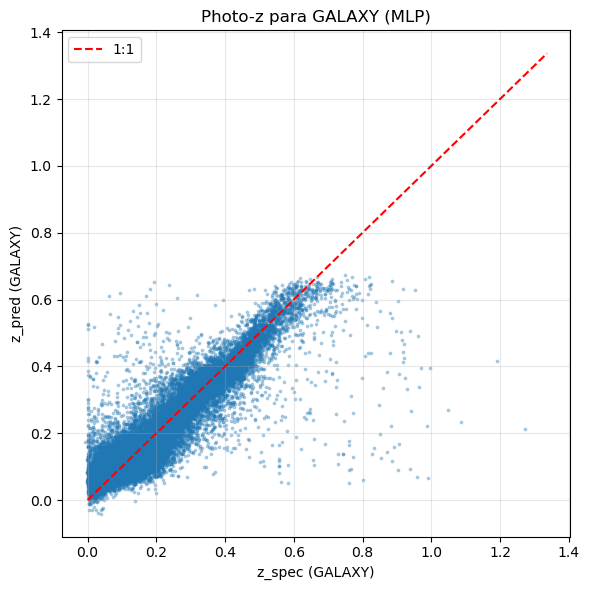

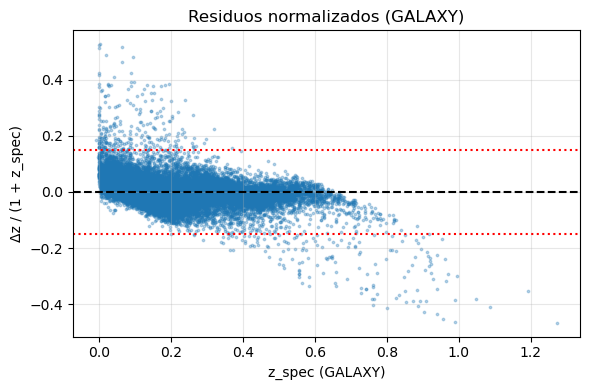

In [10]:
from sklearn.neural_network import MLPRegressor

# Dataset de galaxias
mask_gal = (df["class"] == "GALAXY") & df["z"].notna()
df_gal = df[mask_gal].copy()

print("N galaxias con z:", df_gal.shape[0])
df_gal["z"].describe()

# Features: mismos colores + una magnitud (psfMag_r)
features_z_gal = ["u_g", "g_r", "r_i", "i_z", "psfMag_r"]

X_gal = df_gal[features_z_gal].values.astype(float)
y_gal = df_gal["z"].values.astype(float)


# Train–test split estratificado en z
# bindeamos z para stratify (bins de ~0.1)
z_bins_gal = np.clip((y_gal / 0.1).astype(int), 0, 50)

X_tr_gal, X_te_gal, y_tr_gal, y_te_gal = train_test_split(
    X_gal, y_gal,
    test_size = 0.2,
    random_state = 42,
    stratify = z_bins_gal
)

print("Train GALAXY:", X_tr_gal.shape, "Test GALAXY:", X_te_gal.shape)



# Escalado + MLPRegressor

scaler_gal = StandardScaler()
X_trs_gal = scaler_gal.fit_transform(X_tr_gal)
X_tes_gal = scaler_gal.transform(X_te_gal)

mlp_z_gal = MLPRegressor(
    hidden_layer_sizes = (64, 32),
    activation = "relu",
    solver = "adam",
    learning_rate_init = 1e-3,
    alpha = 1e-4,
    max_iter = 600,
    early_stopping = True,
    n_iter_no_change = 15,
    validation_fraction = 0.1,
    random_state = 42
)

mlp_z_gal.fit(X_trs_gal, y_tr_gal)
z_pred_gal = mlp_z_gal.predict(X_tes_gal)

# Métricas de photo-z (GALAXY)
dz_gal = z_pred_gal - y_te_gal
dz_norm_gal = dz_gal / (1.0 + y_te_gal)

bias_g = np.mean(dz_norm_gal)
sigma_g = np.std(dz_norm_gal)
nmad_g = 1.48 * np.median(np.abs(dz_norm_gal - np.median(dz_norm_gal)))
outliers_g = np.mean(np.abs(dz_norm_gal) > 0.15)  # criterio típico

print("[GALAXY] bias(Δz/(1 + z)):", bias_g)
print("[GALAXY] sigma(Δz/(1 + z)):", sigma_g)
print("[GALAXY] NMAD:", nmad_g)
print("[GALAXY] Outlier fraction:", outliers_g)


# Gráficos (GALAXY)

# z_spec vs z_pred
plt.figure(figsize = (6,6))
plt.scatter(y_te_gal, z_pred_gal, s = 3, alpha = 0.3)
lim_min = 0
lim_max = max(y_te_gal.max(), z_pred_gal.max()) * 1.05
plt.plot([lim_min, lim_max], [lim_min, lim_max], "r--", label = "1:1")
plt.xlabel("z_spec (GALAXY)")
plt.ylabel("z_pred (GALAXY)")
plt.title("Photo-z para GALAXY (MLP)")
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# Δz/(1 + z_spec) vs z_spec
plt.figure(figsize = (6,4))
plt.scatter(y_te_gal, dz_norm_gal, s = 3, alpha = 0.3)
plt.axhline(0, color = "k", linestyle = "--")
plt.axhline(0.15, color = "r", linestyle = ":")
plt.axhline(-0.15, color = "r", linestyle = ":")
plt.xlabel("z_spec (GALAXY)")
plt.ylabel("Δz / (1 + z_spec)")
plt.title("Residuos normalizados (GALAXY)")
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()




N QSO con z en [0,5]: 35959
Train QSO: (28767, 5) Test QSO: (7192, 5)
[QSO] bias(Δz/(1 + z)): 0.04918987423880577
[QSO] sigma(Δz/(1 + z)): 0.22310190531707808
[QSO] NMAD: 0.10480032637349528
[QSO] Outlier fraction: 0.30770300333704115


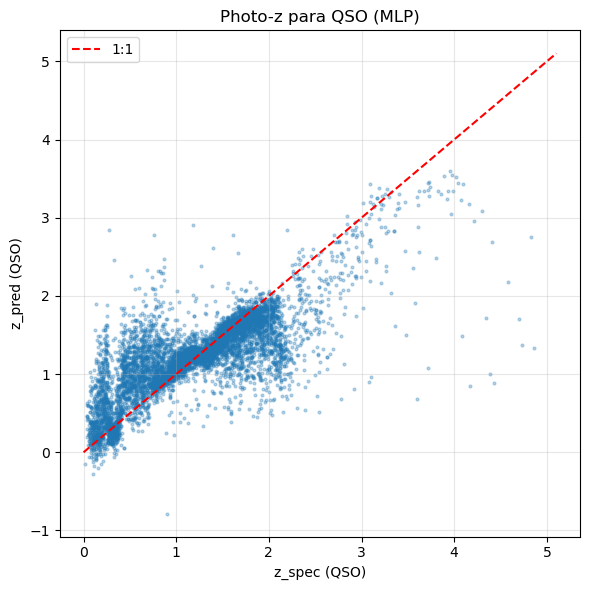

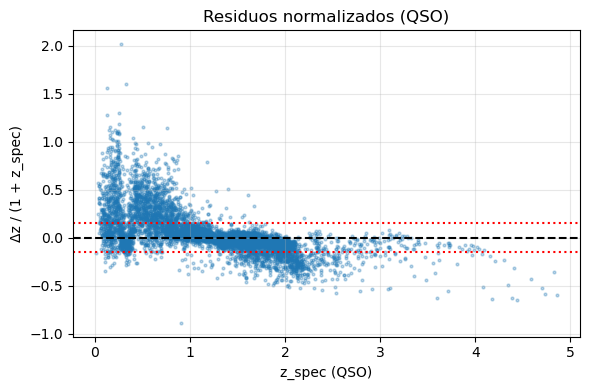

In [11]:
# Dataset de QSO
mask_qso = (df["class"] == "QSO") & df["z"].notna()
df_qso = df[mask_qso].copy()

# corte suave en z para evitar valores extremos
df_qso = df_qso[(df_qso["z"] > 0.0) & (df_qso["z"] < 5.0)].copy()

print("N QSO con z en [0,5]:", df_qso.shape[0])
df_qso["z"].describe()

# Features: mismos colores + una magnitud (psfMag_i)
features_z_qso = ["u_g", "g_r", "r_i", "i_z", "psfMag_i"]

X_qso = df_qso[features_z_qso].values.astype(float)
y_qso = df_qso["z"].values.astype(float)


# Train–test split estratificado en z

# bins más gruesos (~0.2) porque z_QSO cubre rango más amplio
z_bins_qso = np.clip((y_qso / 0.2).astype(int), 0, 50)

X_tr_qso, X_te_qso, y_tr_qso, y_te_qso = train_test_split(
    X_qso, y_qso,
    test_size = 0.2,
    random_state = 42,
    stratify = z_bins_qso
)

print("Train QSO:", X_tr_qso.shape, "Test QSO:", X_te_qso.shape)


# Escalado + MLPRegressor
scaler_qso = StandardScaler()
X_trs_qso = scaler_qso.fit_transform(X_tr_qso)
X_tes_qso = scaler_qso.transform(X_te_qso)

mlp_z_qso = MLPRegressor(
    hidden_layer_sizes = (128, 64),
    activation = "relu",
    solver = "adam",
    learning_rate_init = 1e-3,
    alpha = 1e-4,
    max_iter = 600,
    early_stopping = True,
    n_iter_no_change = 15,
    validation_fraction = 0.1,
    random_state = 42
)

mlp_z_qso.fit(X_trs_qso, y_tr_qso)
z_pred_qso = mlp_z_qso.predict(X_tes_qso)


# Métricas de photo-z (QSO)
dz_qso = z_pred_qso - y_te_qso
dz_norm_qso = dz_qso / (1.0 + y_te_qso)

bias_q = np.mean(dz_norm_qso)
sigma_q = np.std(dz_norm_qso)
nmad_q = 1.48 * np.median(np.abs(dz_norm_qso - np.median(dz_norm_qso)))
outliers_q = np.mean(np.abs(dz_norm_qso) > 0.15)

print("[QSO] bias(Δz/(1 + z)):", bias_q)
print("[QSO] sigma(Δz/(1 + z)):", sigma_q)
print("[QSO] NMAD:", nmad_q)
print("[QSO] Outlier fraction:", outliers_q)


# Gráficos (QSO)
# z_spec vs z_pred
plt.figure(figsize = (6,6))
plt.scatter(y_te_qso, z_pred_qso, s = 4, alpha = 0.3)
lim_min_q = 0
lim_max_q = max(y_te_qso.max(), z_pred_qso.max()) * 1.05
plt.plot([lim_min_q, lim_max_q], [lim_min_q, lim_max_q], "r--", label = "1:1")
plt.xlabel("z_spec (QSO)")
plt.ylabel("z_pred (QSO)")
plt.title("Photo-z para QSO (MLP)")
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# Δz / (1+z_spec) vs z_spec
plt.figure(figsize = (6,4))
plt.scatter(y_te_qso, dz_norm_qso, s = 4, alpha = 0.3)
plt.axhline(0, color = "k", linestyle = "--")
plt.axhline(0.15, color = "r", linestyle = ":")
plt.axhline(-0.15, color = "r", linestyle = ":")
plt.xlabel("z_spec (QSO)")
plt.ylabel("Δz / (1 + z_spec)")
plt.title("Residuos normalizados (QSO)")
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()


In [12]:
def eval_photoz_for_class(df_sub, features_z, arch, name,
                          z_min = None, z_max = None,
                          z_bin_width = 0.1, random_state = 42):
    """
    df_sub: DataFrame filtrado a GALAXY o QSO
    features_z: lista de features (colores + magnitud)
    arch: hidden_layer_sizes, p.ej. (64,32)
    name: 'GALAXY' o 'QSO'
    z_min/z_max: cortes en z
    z_bin_width: ancho de bin
    """
    dfc = df_sub.copy()
    dfc = dfc[dfc["z"].notna()]
    if z_min is not None:
        dfc = dfc[dfc["z"] >= z_min]
    if z_max is not None:
        dfc = dfc[dfc["z"] <= z_max]

    if dfc.empty:
        raise ValueError(f"No hay objetos para {name} después de los cortes en z")

    X = dfc[features_z].values.astype(float)
    y = dfc["z"].values.astype(float)

    # Estratificamos en z
    z_bins = np.clip((y / z_bin_width).astype(int), 0, 100)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size = 0.2,
        random_state = random_state,
        stratify = z_bins
    )

    scaler = StandardScaler()
    X_trs = scaler.fit_transform(X_tr)
    X_tes = scaler.transform(X_te)

    mlp = MLPRegressor(
        hidden_layer_sizes = arch,
        activation = "relu",
        solver = "adam",
        learning_rate_init = 5e-4,
        alpha = 5e-4,
        max_iter = 600,
        early_stopping = True,
        n_iter_no_change = 15,
        validation_fraction = 0.1,
        random_state = random_state
    )

    mlp.fit(X_trs, y_tr)
    z_pred = mlp.predict(X_tes)

    dz = z_pred - y_te
    dz_norm = dz / (1.0 + y_te)

    bias = np.mean(dz_norm)
    sigma = np.std(dz_norm)
    nmad = 1.48 * np.median(np.abs(dz_norm - np.median(dz_norm)))
    outliers = np.mean(np.abs(dz_norm) > 0.15)

    return {
        "Clase": name,
        "Arquitectura": str(arch),
        "N_test": len(y_te),
        "bias": bias,
        "sigma": sigma,
        "NMAD": nmad,
        "Outlier_frac": outliers
    }

# Definimos subconjuntos y features para GALAXY y QSO

# GALAXY: sin cortes fuertes de z
mask_gal = (df["class"] == "GALAXY") & df["z"].notna()
df_gal = df[mask_gal].copy()
features_z_gal = ["u_g","g_r","r_i","i_z","psfMag_r"]

# QSO: rango razonable en z (0 < z < 5)
mask_qso = (df["class"] == "QSO") & df["z"].notna()
df_qso = df[mask_qso].copy()
features_z_qso = ["u_g","g_r","r_i","i_z","psfMag_i"]

print("N GALAXY:", df_gal.shape[0])
print("N QSO (sin cortes):", df_qso.shape[0])


# Probamos distintas arquitecturas para ambas clases
architectures = [
    (32,),
    (64, 32),
    (128, 64),
    (256, 128),
]

results = []

for arch in architectures:
    # GALAXY
    res_g = eval_photoz_for_class(
        df_sub = df_gal,
        features_z = features_z_gal,
        arch = arch,
        name = "GALAXY",
        z_min = None,
        z_max = None,
        z_bin_width = 0.1
    )
    results.append(res_g)

    # QSO (corte en z para evitar extremos)
    res_q = eval_photoz_for_class(
        df_sub = df_qso,
        features_z = features_z_qso,
        arch = arch,
        name = "QSO",
        z_min = 0.0,
        z_max = 5.0,
        z_bin_width = 0.2
    )
    results.append(res_q)


# Tabla resumen
res_df = pd.DataFrame(results)

# Para ver primero las mejores (menor NMAD, luego menor outliers)
res_df_sorted = res_df.sort_values(
    by = ["Clase", "NMAD", "Outlier_frac"],
    ascending = [True, True, True]
).reset_index(drop = True)

# Formato cute
def fmt_pct(x):
    return f"{100*x:5.2f}%"

res_show = res_df_sorted.copy()
res_show["sigma"] = res_show["sigma"].map(lambda x: f"{x:.4f}")
res_show["bias"] = res_show["bias"].map(lambda x: f"{x:.4f}")
res_show["NMAD"] = res_show["NMAD"].map(lambda x: f"{x:.4f}")
res_show["Outlier_frac"] = res_show["Outlier_frac"].map(fmt_pct)

display(res_show)

N GALAXY: 315305
N QSO (sin cortes): 36182


,Clase,Arquitectura,N_test,bias,sigma,NMAD,Outlier_frac
0,GALAXY,"(64, 32)",63061,0.0025,0.0413,0.0263,0.72%
1,GALAXY,"(256, 128)",63061,-0.0060,0.0798,0.0266,0.84%
2,GALAXY,"(128, 64)",63061,0.0102,0.4389,0.0281,0.95%
3,GALAXY,"(32,)",63061,0.0035,0.2918,0.0359,1.26%
4,QSO,"(256, 128)",7192,0.0410,0.2391,0.1363,37.21%
5,QSO,"(128, 64)",7192,0.0493,0.2396,0.1385,37.47%
6,QSO,"(64, 32)",7192,0.0559,0.2422,0.1401,37.47%
7,QSO,"(32,)",7192,0.0601,0.2538,0.1722,42.12%
